In [184]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import LSTM
from keras.models import Sequential
import seaborn as sns
sns.set_theme(style="whitegrid")

### Reading Dataset

In [6]:
df_k = pd.read_csv('Gold Price (2013-2023).csv')

In [7]:
df = pd.read_csv('Gold_Price_daily.csv')

In [8]:
df = df.drop(columns={'Adj Close', 'Volume'})
df

,Date,Close,High,Low,Open
0,NaN,GC=F,GC=F,GC=F,GC=F
1,2014-12-09,1231.5,1238.0,1202.0,1202.0
2,2014-12-10,1228.9000244140625,1234.5999755859375,1226.5999755859375,1231.199951171875
3,2014-12-11,1225.0999755859375,1231.199951171875,1216.199951171875,1226.5999755859375
4,2014-12-12,1222.0,1227.800048828125,1216.199951171875,1227.800048828125
...,...,...,...,...,...
2511,2024-12-03,2644.699951171875,2654.699951171875,2636.0,2639.0
2512,2024-12-04,2653.800048828125,2658.300048828125,2637.0,2639.199951171875
2513,2024-12-05,2626.60009765625,2655.0,2625.699951171875,2652.39990234375
2514,2024-12-06,2638.60009765625,2643.10009765625,2617.5,2620.199951171875


In [9]:
df.dropna(inplace=True)

In [10]:
df_k

,Date,Price,Open,High,Low,Vol.,Change %
0,12/30/2022,"1,826.20","1,821.80","1,832.40","1,819.80",107.50K,0.01%
1,12/29/2022,"1,826.00","1,812.30","1,827.30","1,811.20",105.99K,0.56%
2,12/28/2022,"1,815.80","1,822.40","1,822.80","1,804.20",118.08K,-0.40%
3,12/27/2022,"1,823.10","1,808.20","1,841.90","1,808.00",159.62K,0.74%
4,12/26/2022,"1,809.70","1,805.80","1,811.95","1,805.55",NaN,0.30%
...,...,...,...,...,...,...,...
2578,01/08/2013,"1,663.20","1,651.50","1,662.60","1,648.80",0.13K,0.97%
2579,01/07/2013,"1,647.20","1,657.30","1,663.80","1,645.30",0.09K,-0.16%
2580,01/04/2013,"1,649.90","1,664.40","1,664.40","1,630.00",0.31K,-1.53%
2581,01/03/2013,"1,675.60","1,688.00","1,689.30","1,664.30",0.19K,-0.85%


In [11]:
df.rename(columns={'Close': 'Price'}, inplace=True)

In [13]:
df

,Date,Price,High,Low,Open
1,2014-12-09,1231.5,1238.0,1202.0,1202.0
2,2014-12-10,1228.9000244140625,1234.5999755859375,1226.5999755859375,1231.199951171875
3,2014-12-11,1225.0999755859375,1231.199951171875,1216.199951171875,1226.5999755859375
4,2014-12-12,1222.0,1227.800048828125,1216.199951171875,1227.800048828125
5,2014-12-15,1207.199951171875,1223.0999755859375,1198.4000244140625,1223.0999755859375
...,...,...,...,...,...
2511,2024-12-03,2644.699951171875,2654.699951171875,2636.0,2639.0
2512,2024-12-04,2653.800048828125,2658.300048828125,2637.0,2639.199951171875
2513,2024-12-05,2626.60009765625,2655.0,2625.699951171875,2652.39990234375
2514,2024-12-06,2638.60009765625,2643.10009765625,2617.5,2620.199951171875


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2515 entries, 1 to 2515
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    2515 non-null   object
 1   Price   2515 non-null   object
 2   High    2515 non-null   object
 3   Low     2515 non-null   object
 4   Open    2515 non-null   object
dtypes: object(5)
memory usage: 117.9+ KB


### Data preparation

In [22]:
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

In [28]:
# checking for duplicate
df.duplicated().sum()

0

In [195]:
# checking for missing values 
df.isnull().sum().sum()

0

**Gold price visualization**

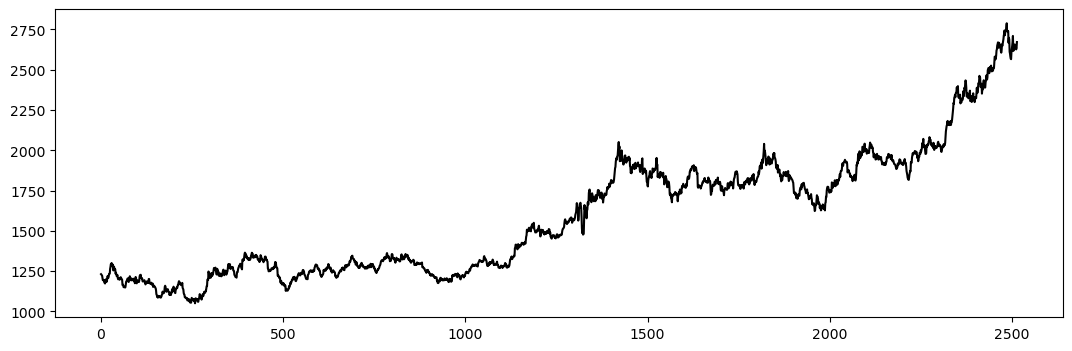

In [32]:
plt.figure(figsize=(13,4))
df['Price'].plot(color='black')
plt.show()

**setting the test size**

In [103]:
# deifne the number of days for test size
test_size = 60
test_size

60

**Gold Price Training and Test Sets Plot**

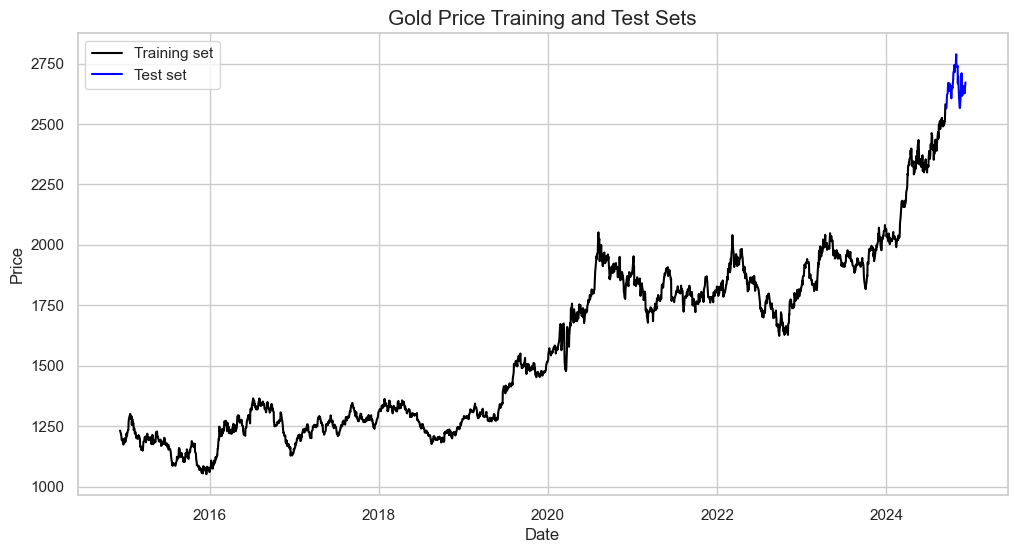

In [186]:
plt.figure(figsize=(12, 6))
plt.plot(df['Date'][:-test_size], df['Price'][:-test_size], color='black')
plt.plot(df['Date'][-test_size:], df['Price'][-test_size:], color='blue')
plt.title('Gold Price Training and Test Sets', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training set', 'Test set'], loc='upper left')
plt.show()

In [108]:
# scaling the data
scaler = MinMaxScaler()
scaler.fit(df['Price'].values.reshape(-1,1))

MinMaxScaler()

In [110]:
# Setting window size 
window_size = 60 #(60 days)

**Training Set:**

In [113]:
train_data = df['Price'][:-test_size]
train_data = scaler.transform(train_data.values.reshape(-1,1))

In [115]:
X_train = []
y_train = []

for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-window_size:i, 0])
    y_train.append(train_data[i, 0])

**Testing Set:**

In [118]:
test_data = df['Price'][-test_size-window_size:]
test_data = scaler.transform(test_data.values.reshape(-1,1))

In [120]:
X_test = []
y_test = []

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-window_size:i, 0])
    y_test.append(test_data[i, 0])

**Convert the data into acceptable format**

In [122]:
# convert into data format that accepting by the model
X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test  = np.array(y_test)

In [124]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1,1))
y_test  = np.reshape(y_test, (-1,1))

In [126]:
print('X_train Shape: ', X_train.shape)
print('y_train Shape: ', y_train.shape)
print('X_test Shape:  ', X_test.shape)
print('y_test Shape:  ', y_test.shape)

X_train Shape:  (2395, 60, 1)
y_train Shape:  (2395, 1)
X_test Shape:   (60, 60, 1)
y_test Shape:   (60, 1)


**Creating Model**

In [129]:
def define_model():
    input1 = Input(shape=(window_size,1))
    x = LSTM(units = 64, return_sequences=True)(input1)  
    x = Dropout(0.2)(x)
    x = LSTM(units = 64, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(units = 64)(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='softmax')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer='Nadam')
    model.summary()
    
    return model


**Model training**

In [ ]:
import time 
t0 = time.time()

model = define_model()
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.1, verbose=0)

print(f'How long is this take to run: {time.time() - t0}')

**Evaluate the model**

In [134]:
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test) 

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1988 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


In [157]:
MSE = mean_squared_error(y_test, y_pred)

In [159]:
print("Test Loss:", result)
print("Test MSE:", MSE)

Test Loss: 0.1975564807653427
Test MSE: 0.19755648881936633


In [161]:
# Inverse it to the normal scale 
y_test_true = scaler.inverse_transform(y_test)
y_test_pred = scaler.inverse_transform(y_pred)

In [163]:
MSE = mean_squared_error(y_test_true, y_test_pred)
print("Test Loss:", result)
print("Test MSE:", MSE)

Test Loss: 0.1975564807653427
Test MSE: 596541.8048510768


**Investigating the prices predicted with actual**

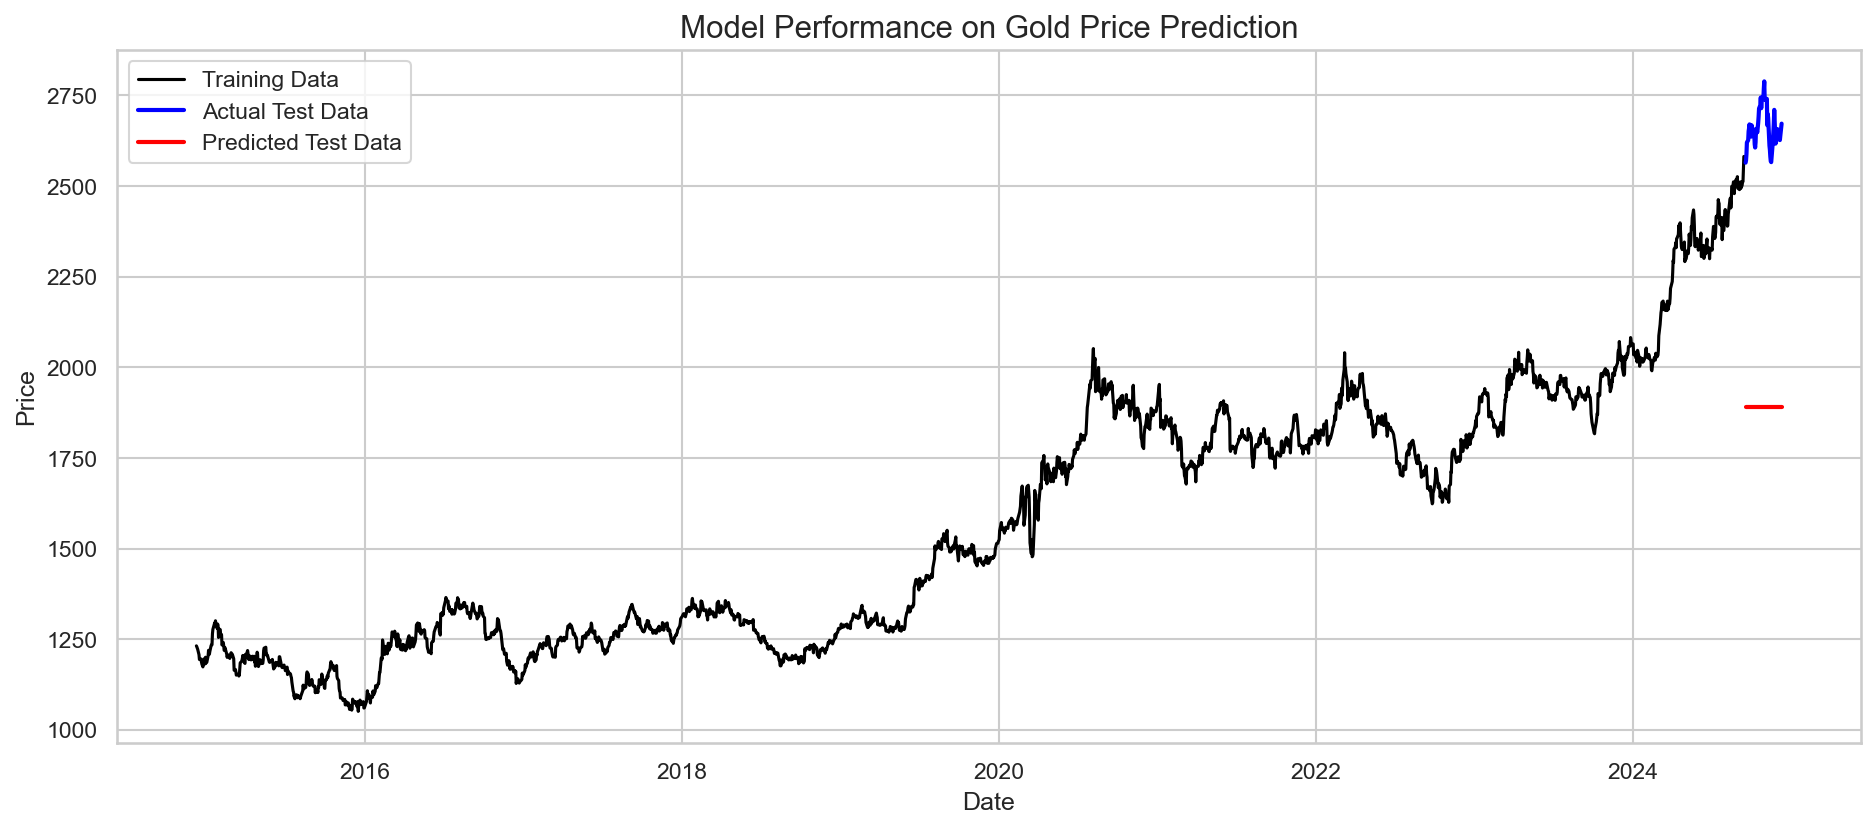

In [188]:
plt.figure(figsize=(15, 6), dpi=150)
plt.plot(df['Date'].iloc[:-test_size], scaler.inverse_transform(train_data), color='black')
plt.plot(df['Date'].iloc[-test_size:], y_test_true, color='blue', lw=2)
plt.plot(df['Date'].iloc[-test_size:], y_test_pred, color='red', lw=2)
plt.title('Model Performance on Gold Price Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training Data', 'Actual Test Data', 'Predicted Test Data'], loc='upper left')
plt.show()